### LSTM - Feature columns: All Features || Prediction: Pickup count by Borough

In [3]:
import os
import sys

module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

# FIX ME: Root dir as argument
root_dir = "../../data/picklerCheckpoints/"
is_compressed = True;
os.environ["CUDA_VISIBLE_DEVICES"] = "-1"

In [4]:
import numpy as np
import pandas as pd
import nbimporter
import geopandas as gpd
import commons.utility.pickle_util as pickle
import Preprocessing.SpatialMapping as sm
import Preprocessing.Discretization as dis
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
import time
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()
import tensorflow as tf

coord_system = {'init': 'epsg:4326'}

Importing Jupyter notebook from D:\Academics\MLRepoFeb\ML2020-Uber-Data-Analysis\commons\utility\pickle_util.ipynb
Importing Jupyter notebook from D:\Academics\MLRepoFeb\ML2020-Uber-Data-Analysis\Preprocessing\SpatialMapping.ipynb
Importing Jupyter notebook from D:\Academics\MLRepoFeb\ML2020-Uber-Data-Analysis\Preprocessing\DataEnrichment.ipynb
Importing Jupyter notebook from D:\Academics\MLRepoFeb\ML2020-Uber-Data-Analysis\Preprocessing\Discretization.ipynb


In [5]:
import numpy as np
import matplotlib.pyplot as plt
from pandas import DataFrame
from pandas import concat
from matplotlib import pyplot

In [6]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout
from keras.preprocessing.sequence import TimeseriesGenerator
import keras
from keras import layers

In [7]:
data = sm.run(['apr', 'may', 'jun', 'jul', 'aug'])

Data for the month :apr Found.....
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
Loading file ../data/picklerCheckpoints/spatialJoinData/uber-spatial-data-apr14.p
Decompressing ../data/picklerCheckpoints/spatialJoinData/uber-spatial-data-apr14.p.pbz2..............Done
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++

Data for the month :may Found.....
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
Loading file ../data/picklerCheckpoints/spatialJoinData/uber-spatial-data-may14.p
Decompressing ../data/picklerCheckpoints/spatialJoinData/uber-spatial-data-may14.p.pbz2..............Done
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++

Data for the month :jun Found.....
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
Loading file

In [8]:
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    """
    Frame a time series as a supervised learning dataset.
    Arguments:
        data: Sequence of observations as a list or NumPy array.
        n_in: Number of lag observations as input (X).
        n_out: Number of observations as output (y).
        dropnan: Boolean whether or not to drop rows with NaN values.
    Returns:
        Pandas DataFrame of series framed for supervised learning.
    """
    n_vars = 1 if type(data) is list else data.shape[1]
    df = DataFrame(data)
    cols, names = list(), list()
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('var%d(t-%d)' % (j + 1, i)) for j in range(n_vars)]
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('var%d(t)' % (j + 1)) for j in range(n_vars)]
        else:
            names += [('var%d(t+%d)' % (j + 1, i)) for j in range(n_vars)]
    # put it all together
    agg = concat(cols, axis=1)
    agg.columns = names
    # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return agg

In [9]:
def ljust(lst, n, fillvalue=0):
    return lst + [fillvalue] * (n - len(lst))

In [10]:
def transposeZones(df2, column):
    dftest = df2[['datetime', column, 'pickups']]
    dftest = dftest.sort_values(['datetime', column], ascending=[True, True]).set_index('datetime')
    #dftest.head(len(dftest.zone.unique())-1)
    zone_order = dftest[column].unique()
#     print(zone_order)
    dftest = dftest.groupby('datetime').agg({lambda x: x.tolist()})
    a = dftest.loc[:, ['pickups']].T
    b = dftest.loc[:, [column]].T
    N = len(zone_order)
    M = np.shape(a)[1]
    acc = []
    idx = 0
    for date in a.columns:
        sub_list_start = 0
        sub_list_end = len(a[date])
        row = a[date].values[0]
        acc.append(ljust(row, N))
       # zeros[idx][sub_list_start : sub_list_end+1] = a[date]
        idx = idx + 1
#     print(acc[0])
    zoneDf = pd.DataFrame(acc, columns=zone_order)
    df3 = df2[['datetime', 'dayOfWeek', 'hourOfDay', 'humidity', 'pressure', 'temperature', 'windDirection', 'holiday', 'windSpeed']].drop_duplicates().reset_index()
    return pd.merge(df3, zoneDf, left_index=True, right_index=True).drop(['index', 'datetime'], 1)

In [11]:
df = data.copy()

In [12]:
df2 = df[['datetime', 'borough', 'weatherCondition', 'humidity', 'pressure', 'temperature', 'windDirection', 'windSpeed', 'holiday']]

In [13]:
df2 = dis.encode(df2, ['holiday', 'weatherCondition', 'borough'])

D:\Academics\MLRepoFeb\ML2020-Uber-Data-Analysis\Preprocessing\Discretization.ipynb:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  "metadata": {},


Result Saved in ../data/encodedMappings/holiday.p
Result Saved in ../data/encodedMappings/weatherCondition.p
Result Saved in ../data/encodedMappings/borough.p


In [14]:
df2['dayOfWeek'] = pd.to_datetime(df2['datetime'], format='%m-%d-%Y:%H')
df2['hourOfDay'] =  pd.to_datetime(df2['datetime'], format='%m-%d-%Y:%H')
df2['dayOfWeek'] = df2['dayOfWeek'].dt.day_name()
df2['hourOfDay'] = df2['hourOfDay'].dt.hour

<ipython-input-14-9ac9e5788ff7>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df2['dayOfWeek'] = pd.to_datetime(df2['datetime'], format='%m-%d-%Y:%H')
<ipython-input-14-9ac9e5788ff7>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df2['hourOfDay'] =  pd.to_datetime(df2['datetime'], format='%m-%d-%Y:%H')
<ipython-input-14-9ac9e5788ff7>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in 

In [15]:
week_dict = {
    "Sunday": 1,
    "Monday": 2,
    "Tuesday": 3,
    "Wednesday":4,
    "Thursday":5,
    "Friday": 6,
    "Saturday": 7
}

In [16]:
df2['dayOfWeek'] = df2.dayOfWeek.apply(lambda x: week_dict[x])

<ipython-input-16-35d0f5211b87>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df2['dayOfWeek'] = df2.dayOfWeek.apply(lambda x: week_dict[x])


In [17]:
# data

In [18]:
# cols_to_norm = ['humidity','pressure', 'temperature', 'windDirection', 'windSpeed']
# df2[cols_to_norm] = df2[cols_to_norm].apply(lambda x: (x - x.min()) / (x.max() - x.min()))

In [19]:
feature_cols = ['datetime', 'borough', 'dayOfWeek', 'hourOfDay', 'humidity','pressure', 'temperature', 'windDirection', 'holiday', 'windSpeed']
df2 = df2[feature_cols]
N = len(df2['borough'].unique())

In [20]:
df2 = df2.groupby(feature_cols).size().reset_index(name='pickups')

In [21]:
# pickups = df2['pickups']
# pickups.pop(0)
# pickups.reset_index(inplace=True, drop=True)
# df2.drop(df2.tail(1).index,inplace=True)

In [22]:
# df2['Pickups_t-1h'] = pickups 
# df2['zone'] = df2['borough']

In [23]:
df2 = transposeZones(df2, 'borough')

In [24]:
df2

,dayOfWeek,hourOfDay,humidity,pressure,temperature,windDirection,holiday,windSpeed,1,3,4,2,0,5
0,3,0,40.0,1016.0,282.96,330.0,1,5.0,26,239,16,0,0,0
1,3,3,60.0,1018.0,278.07,20.0,1,6.0,33,2,133,12,0,0
2,3,4,60.0,1019.0,277.19,360.0,1,4.0,62,4,212,23,0,0
3,3,5,60.0,1019.0,276.49,340.0,1,4.0,2,125,4,447,44,0
4,3,6,64.0,1020.0,275.99,290.0,1,3.0,9,192,3,1289,54,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3629,1,19,46.0,1016.0,303.45,230.0,2,7.0,27,497,15,1775,256,0
3630,1,20,46.0,1015.0,302.18,220.0,2,6.0,45,574,13,1458,267,2
3631,1,21,88.0,1016.0,299.70,240.0,2,6.0,22,570,12,1726,317,4
3632,1,22,94.0,1015.0,298.71,0.0,2,1.0,37,497,16,1702,274,2


In [25]:
# feature_cols = ['datetime', 'zone', 'dayOfWeek', 'hourOfDay', 'humidity','pressure', 'temperature', 'windDirection', 'windSpeed', 'Pickups_t-1h', 'pickups']
# df2 = df2[feature_cols]

In [26]:
values = df2.values
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(df2)

In [27]:
reframed = series_to_supervised(scaled, 7, N)

In [28]:
listOfDrops = []
for i in range(7*len(df2.columns),len(reframed.columns)):
    listOfDrops.append(i)

# print("list of drops ", listOfDrops)
reframed.drop(reframed.columns[listOfDrops], axis=1, inplace=True)

In [29]:
values = reframed.values

In [30]:
np.shape(df2)

(3634, 14)

In [31]:
# split into train and test sets
values = reframed.values
n_train_hours = 3000 
train = values[:n_train_hours, :]
test = values[n_train_hours:, :]
# split into input and outputs
train_X, train_y = train[:, :-N], train[:, -N:]
test_X, test_y = test[:, :-N], test[:, -N:]
# reshape input to be 3D [samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)


(3000, 1, 92) (3000, 6) (622, 1, 92) (622, 6)


In [32]:
reframed

,var1(t-7),var2(t-7),var3(t-7),var4(t-7),var5(t-7),var6(t-7),var7(t-7),var8(t-7),var9(t-7),var10(t-7),...,var5(t-1),var6(t-1),var7(t-1),var8(t-1),var9(t-1),var10(t-1),var11(t-1),var12(t-1),var13(t-1),var14(t-1)
7,0.333333,0.000000,0.333333,0.425532,0.309007,0.916667,0.5,0.416667,0.090253,0.254002,...,0.076745,0.916667,0.5,0.250000,0.014440,0.186766,0.001378,0.217729,0.174334,0.000000
8,0.333333,0.130435,0.555556,0.468085,0.167391,0.055556,0.5,0.500000,0.115523,0.001067,...,0.066319,0.861111,0.5,0.250000,0.003610,0.150480,0.000551,0.143038,0.145278,0.111111
9,0.333333,0.173913,0.555556,0.489362,0.141906,1.000000,0.5,0.333333,0.220217,0.003202,...,0.066319,0.888889,0.5,0.250000,0.014440,0.088581,0.002205,0.129083,0.133172,0.333333
10,0.333333,0.217391,0.555556,0.489362,0.121633,0.944444,0.5,0.333333,0.003610,0.132337,...,0.072111,0.972222,0.5,0.250000,0.014440,0.107791,0.258269,0.010942,0.000000,0.000000
11,0.333333,0.260870,0.600000,0.510638,0.107153,0.805556,0.5,0.250000,0.028881,0.203842,...,0.120185,0.944444,0.5,0.333333,0.025271,0.100320,0.001654,0.124326,0.130751,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3624,0.000000,0.304348,0.811111,0.531915,0.649290,0.527778,1.0,0.250000,0.050542,0.169691,...,0.676513,0.638889,1.0,0.333333,0.101083,0.485592,0.004410,0.244529,0.578692,0.000000
3625,0.000000,0.347826,0.811111,0.510638,0.648711,0.555556,1.0,0.333333,0.043321,0.284952,...,0.703446,0.555556,1.0,0.250000,0.119134,0.588047,0.004686,0.270536,0.598063,0.000000
3626,0.000000,0.391304,0.700000,0.510638,0.651318,0.527778,1.0,0.250000,0.054152,0.381003,...,0.752389,0.611111,1.0,0.416667,0.140794,0.553895,0.003032,0.384237,0.646489,0.333333
3627,0.000000,0.434783,0.755556,0.510638,0.650449,0.555556,1.0,0.250000,0.064982,0.324440,...,0.798726,0.638889,1.0,0.500000,0.126354,0.560299,0.003032,0.408024,0.610169,0.000000


In [33]:
NumOfEpochs = 300
# design network
model = Sequential()
model.add(layers.LSTM(NumOfEpochs, input_shape=(train_X.shape[1], train_X.shape[2])))
model.add(layers.Dense(N))
model.compile(loss='mae', optimizer='adam', metrics=['accuracy'])
# fit network
start = time.time()
history = model.fit(train_X, train_y, epochs=NumOfEpochs, batch_size=72, validation_data=(test_X, test_y), verbose=2, shuffle=False)
end = time.time()

Epoch 1/300
42/42 - 1s - loss: 0.0733 - accuracy: 0.4137 - val_loss: 0.0684 - val_accuracy: 0.6511
Epoch 2/300
42/42 - 0s - loss: 0.0601 - accuracy: 0.5117 - val_loss: 0.0588 - val_accuracy: 0.6785
Epoch 3/300
42/42 - 0s - loss: 0.0578 - accuracy: 0.4987 - val_loss: 0.0575 - val_accuracy: 0.6913
Epoch 4/300
42/42 - 0s - loss: 0.0555 - accuracy: 0.5217 - val_loss: 0.0577 - val_accuracy: 0.6688
Epoch 5/300
42/42 - 0s - loss: 0.0546 - accuracy: 0.4987 - val_loss: 0.0564 - val_accuracy: 0.6383
Epoch 6/300
42/42 - 0s - loss: 0.0549 - accuracy: 0.4993 - val_loss: 0.0526 - val_accuracy: 0.7026
Epoch 7/300
42/42 - 0s - loss: 0.0527 - accuracy: 0.5373 - val_loss: 0.0561 - val_accuracy: 0.7026
Epoch 8/300
42/42 - 0s - loss: 0.0525 - accuracy: 0.5573 - val_loss: 0.0514 - val_accuracy: 0.7074
Epoch 9/300
42/42 - 0s - loss: 0.0498 - accuracy: 0.5747 - val_loss: 0.0505 - val_accuracy: 0.6961
Epoch 10/300
42/42 - 0s - loss: 0.0488 - accuracy: 0.5813 - val_loss: 0.0514 - val_accuracy: 0.6913
Epoch 11/

42/42 - 0s - loss: 0.0362 - accuracy: 0.6523 - val_loss: 0.0415 - val_accuracy: 0.7428
Epoch 84/300
42/42 - 0s - loss: 0.0361 - accuracy: 0.6523 - val_loss: 0.0417 - val_accuracy: 0.7524
Epoch 85/300
42/42 - 0s - loss: 0.0362 - accuracy: 0.6530 - val_loss: 0.0419 - val_accuracy: 0.7428
Epoch 86/300
42/42 - 0s - loss: 0.0363 - accuracy: 0.6553 - val_loss: 0.0415 - val_accuracy: 0.7460
Epoch 87/300
42/42 - 0s - loss: 0.0362 - accuracy: 0.6517 - val_loss: 0.0416 - val_accuracy: 0.7476
Epoch 88/300
42/42 - 0s - loss: 0.0358 - accuracy: 0.6527 - val_loss: 0.0415 - val_accuracy: 0.7428
Epoch 89/300
42/42 - 0s - loss: 0.0359 - accuracy: 0.6507 - val_loss: 0.0415 - val_accuracy: 0.7428
Epoch 90/300
42/42 - 0s - loss: 0.0360 - accuracy: 0.6497 - val_loss: 0.0416 - val_accuracy: 0.7444
Epoch 91/300
42/42 - 0s - loss: 0.0361 - accuracy: 0.6513 - val_loss: 0.0416 - val_accuracy: 0.7412
Epoch 92/300
42/42 - 0s - loss: 0.0364 - accuracy: 0.6477 - val_loss: 0.0415 - val_accuracy: 0.7460
Epoch 93/300


Epoch 165/300
42/42 - 0s - loss: 0.0337 - accuracy: 0.6757 - val_loss: 0.0451 - val_accuracy: 0.7026
Epoch 166/300
42/42 - 0s - loss: 0.0336 - accuracy: 0.6797 - val_loss: 0.0454 - val_accuracy: 0.7090
Epoch 167/300
42/42 - 0s - loss: 0.0340 - accuracy: 0.6720 - val_loss: 0.0457 - val_accuracy: 0.7203
Epoch 168/300
42/42 - 0s - loss: 0.0342 - accuracy: 0.6670 - val_loss: 0.0460 - val_accuracy: 0.7299
Epoch 169/300
42/42 - 0s - loss: 0.0347 - accuracy: 0.6623 - val_loss: 0.0465 - val_accuracy: 0.7267
Epoch 170/300
42/42 - 0s - loss: 0.0349 - accuracy: 0.6537 - val_loss: 0.0456 - val_accuracy: 0.7219
Epoch 171/300
42/42 - 0s - loss: 0.0344 - accuracy: 0.6623 - val_loss: 0.0452 - val_accuracy: 0.7170
Epoch 172/300
42/42 - 0s - loss: 0.0342 - accuracy: 0.6640 - val_loss: 0.0436 - val_accuracy: 0.7267
Epoch 173/300
42/42 - 0s - loss: 0.0345 - accuracy: 0.6650 - val_loss: 0.0436 - val_accuracy: 0.7170
Epoch 174/300
42/42 - 0s - loss: 0.0342 - accuracy: 0.6663 - val_loss: 0.0447 - val_accurac

42/42 - 0s - loss: 0.0315 - accuracy: 0.7133 - val_loss: 0.0445 - val_accuracy: 0.7074
Epoch 247/300
42/42 - 0s - loss: 0.0313 - accuracy: 0.7093 - val_loss: 0.0442 - val_accuracy: 0.7074
Epoch 248/300
42/42 - 0s - loss: 0.0314 - accuracy: 0.7143 - val_loss: 0.0442 - val_accuracy: 0.7074
Epoch 249/300
42/42 - 0s - loss: 0.0315 - accuracy: 0.7053 - val_loss: 0.0442 - val_accuracy: 0.7074
Epoch 250/300
42/42 - 0s - loss: 0.0315 - accuracy: 0.7053 - val_loss: 0.0447 - val_accuracy: 0.6994
Epoch 251/300
42/42 - 0s - loss: 0.0318 - accuracy: 0.6993 - val_loss: 0.0455 - val_accuracy: 0.6576
Epoch 252/300
42/42 - 0s - loss: 0.0316 - accuracy: 0.7057 - val_loss: 0.0458 - val_accuracy: 0.6720
Epoch 253/300
42/42 - 0s - loss: 0.0316 - accuracy: 0.7020 - val_loss: 0.0465 - val_accuracy: 0.6576
Epoch 254/300
42/42 - 0s - loss: 0.0312 - accuracy: 0.7080 - val_loss: 0.0454 - val_accuracy: 0.6849
Epoch 255/300
42/42 - 0s - loss: 0.0313 - accuracy: 0.7060 - val_loss: 0.0446 - val_accuracy: 0.7090
Epoc

In [34]:
import datetime
plt.rcParams.update({'font.size': 14})

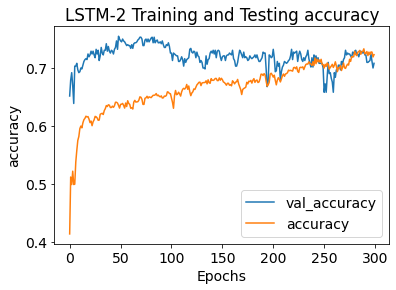

In [35]:
f = pyplot.figure()
pyplot.plot(history.history['val_accuracy'], label='val_accuracy')
pyplot.plot(history.history['accuracy'], label='accuracy')
pyplot.legend()
pyplot.xlabel('Epochs')
pyplot.ylabel('accuracy')
pyplot.title('LSTM-2 Training and Testing accuracy')
pyplot.savefig('LSTM/lstm-2-acc.png')
pyplot.show()
now = datetime.datetime.now()

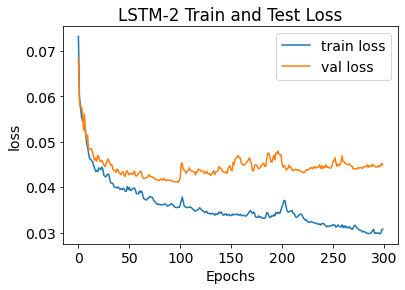

In [36]:
f1 = pyplot.figure()
pyplot.plot(history.history['loss'], label='train loss')
pyplot.plot(history.history['val_loss'], label='val loss')
pyplot.legend()
pyplot.xlabel('Epochs')
pyplot.ylabel('loss')
pyplot.title('LSTM-2 Train and Test Loss')
pyplot.savefig('LSTM/lstm-2-loss.png')
pyplot.show()
now = datetime.datetime.now()


In [37]:
end-start

105.69658994674683

In [38]:
# make a prediction
yhat = model.predict(test_X)

(622, 14)


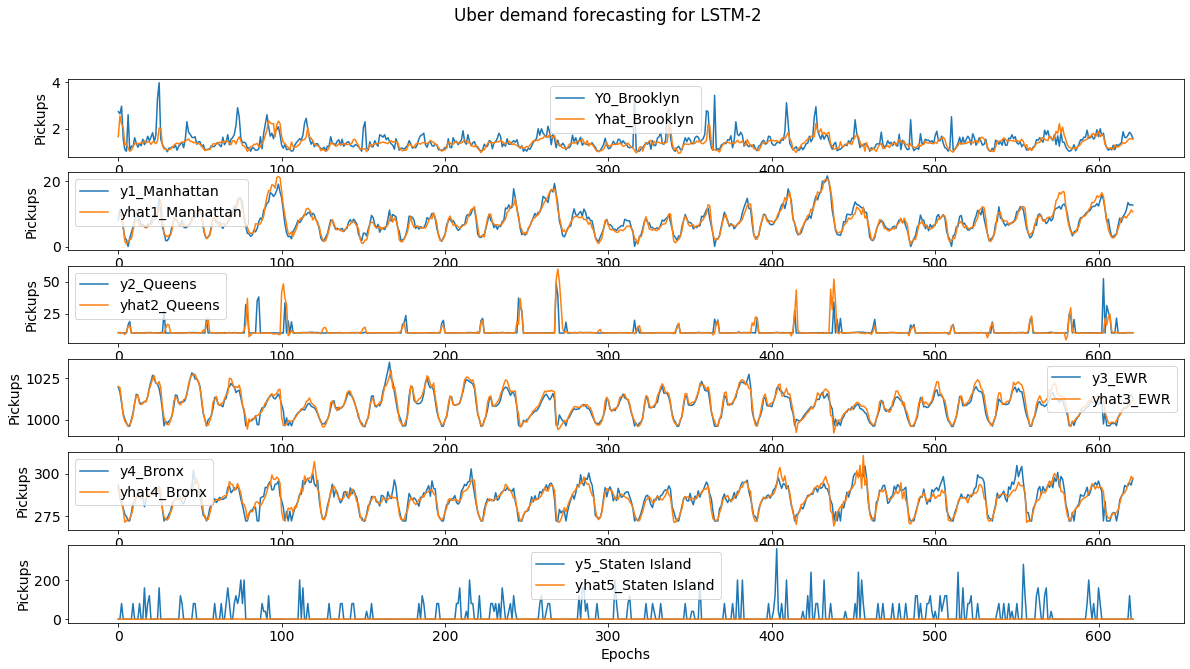

In [39]:
test_X = test_X.reshape((test_X.shape[0], test_X.shape[2]))
# invert scaling for forecast
inv_yhat = np.concatenate((yhat, test_X[:, 84:]), axis=1)
inv_yhat = scaler.inverse_transform(inv_yhat)
inv_yhat = inv_yhat[:,:]
# invert scaling for actual
test_y = test_y.reshape((len(test_y), N))
inv_y = np.concatenate((test_y, test_X[:, 84:]), axis=1)
inv_y = scaler.inverse_transform(inv_y)
inv_y = inv_y[:,:]
print(inv_y.shape)
f3 = pyplot.figure(figsize=(20,10))
pyplot.subplot(6, 1, 1)
pyplot.plot(inv_y[:,0],label='Y0_Brooklyn')
pyplot.plot(inv_yhat[:,0],label='Yhat_Brooklyn')
pyplot.xlabel("Epochs")
pyplot.ylabel("Pickups")
pyplot.legend()

pyplot.subplot(6, 1, 2)
pyplot.plot(inv_y[:,1],label='y1_Manhattan')
pyplot.plot(inv_yhat[:,1],label='yhat1_Manhattan')
pyplot.xlabel("Epochs")
pyplot.ylabel("Pickups")
pyplot.legend()

pyplot.subplot(6, 1, 3)
pyplot.plot(inv_y[:,2],label='y2_Queens')
pyplot.plot(inv_yhat[:,2],label='yhat2_Queens')
pyplot.xlabel("Epochs")
pyplot.ylabel("Pickups")
pyplot.legend()

pyplot.subplot(6, 1, 4)
pyplot.plot(inv_y[:,3],label='y3_EWR')
pyplot.plot(inv_yhat[:,3],label='yhat3_EWR')
pyplot.xlabel("Epochs")
pyplot.ylabel("Pickups")
pyplot.legend()

pyplot.subplot(6, 1, 5)
pyplot.plot(inv_y[:,4],label='y4_Bronx')
pyplot.plot(inv_yhat[:,4],label='yhat4_Bronx')
pyplot.xlabel("Epochs")
pyplot.ylabel("Pickups")
pyplot.legend()

pyplot.subplot(6, 1, 6)
pyplot.plot(inv_y[:,5],label='y5_Staten Island')
pyplot.plot(inv_yhat[:,5],label='yhat5_Staten Island')
pyplot.xlabel("Epochs")
pyplot.ylabel("Pickups")
pyplot.legend()
f3.suptitle('Uber demand forecasting for LSTM-2')

pyplot.savefig('LSTM/LSTM-2_forecast.png')
pyplot.show()
now = datetime.datetime.now()

In [40]:
# calculate RMSE
import math
from sklearn.metrics import mean_squared_error

rmse = math.sqrt(mean_squared_error(inv_y, inv_yhat))
print('Test RMSE: %.3f' % rmse)

Test RMSE: 15.339


In [41]:
abs(end-start)

105.69658994674683